# Data Processing

## Data cleaning 

In [1]:
import pandas as pd
from fuzzywuzzy import fuzz, process

raw_df = pd.read_excel (r'/Users/swimmingcircle/cs156_code/assignments/Final_project/long_form_poll_responses_2019.xlsx')

/Users/swimmingcircle/Library/Python/3.9/lib/python/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
#add time stamp as variable 
raw_df['time_stamp'] = raw_df['Polls ID'].rank(method = 'dense', ascending=True).astype(int)
raw_df.sort_values("time_stamp", inplace = True)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

/Users/swimmingcircle/Library/Python/3.9/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Assessment Score Count')

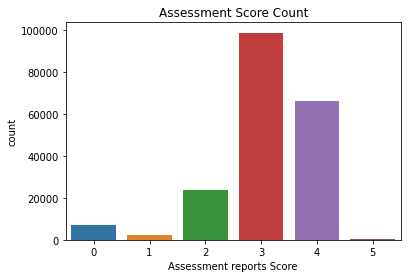

In [4]:
sns.countplot(raw_df['Assessment reports Score'])
plt.title('Assessment Score Count')

In [5]:
#average 
raw_df['Assessment reports Score'].mean()

3.0913772213247173

We can see that most polls are graded as 3, and more polls are graded as 4 than 2. In addition, we see 0 in the grade, which we will need to discard. In addition, the average poll grades is around 3.09.

## Grades for hashtags(HCs & LOs)

In [6]:
avg_grades = pd.DataFrame(raw_df.groupby('Assessment reports Hashtag')['Assessment reports Score'].agg(['mean', 'count']))
avg_grades = avg_grades.sort_values('mean', ascending= False).reset_index()

In [7]:
avg_grades

,Assessment reports Hashtag,mean,count
0,#histonemodifications,4.000000,2
1,#LPimplementation,4.000000,1
2,#networktheory,4.000000,2
3,#Participation,4.000000,3
4,#Preparedness,4.000000,1
...,...,...,...
798,#buckinghampi,2.307692,39
799,#DA,2.285714,49
800,#Rimplementation,2.178571,28
801,#accountability,1.750000,8


From the result, we can see that some hashtags have a high mean because of few data points. We might discard those hashtags if they bais the result. We will preserve the information for now. 

## Discard data 

- Discard polls that have NONE for Assessment reports Hashtag
- Discard polls that have't get graded 


In [8]:
df = raw_df[raw_df['Assessment reports Hashtag'] != 'NONE']
df = raw_df[raw_df['Assessment reports Score'] != 0.0]

In [9]:
df

,Polls ID,Poll Responses Response,Assessment reports Hashtag,Assessment reports Score,time_stamp
0,12522,The strengths of Plato's approach is his const...,#objectivemorality,2,1
16,12522,In the breakout we discussed if outside the ca...,#objectivemorality,3,1
15,12522,"I think he's good at reasoning, but he has thi...",#deductivearg,2,1
14,12522,Back to cmmon confusion time: the section 'und...,#objectivemorality,2,1
13,12522,Most difficult weakness is that his position w...,#objectivemorality,2,1
...,...,...,...,...,...
198045,322265,Definiteness,#algorithmicstrategies,1,15539
198046,322265,I think important propoerties of algorithms in...,#algorithmicstrategies,3,15539
198047,322265,"This is maybe not an additional property, but ...",#algorithmicstrategies,3,15539
198034,322265,comprehensibility. This is related to efficie...,#algorithmicstrategies,3,15539


## Text processing

In [10]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem.snowball import SnowballStemmer
import re
import os
import codecs
from sklearn import feature_extraction
from nltk.tokenize import RegexpTokenizer

In [11]:
# load nltk's English stopwords as variable called 'stopwords'
# use nltk.download() to install the corpus first
# Stop Words are words which do not contain important significance to be used in Search Queries
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['would','could', 'might', 'also', 'use', 'because']
stopwords.extend(newStopWords)


# load nltk's SnowballStemmer as variabled 'stemmer'
stemmer = SnowballStemmer("english")

In [12]:
df['Poll Responses Response'] = df['Poll Responses Response'].apply(str)

#remove numbers 
df['Poll Responses Response'] = df['Poll Responses Response'].str.replace(r'\d+','')

/var/folders/0h/xyv81g2n7sj6zr0c9cw30gkc0000gn/T/ipykernel_11756/2124817980.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Poll Responses Response'] = df['Poll Responses Response'].apply(str)
/var/folders/0h/xyv81g2n7sj6zr0c9cw30gkc0000gn/T/ipykernel_11756/2124817980.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Poll Responses Response'] = df['Poll Responses Response'].str.replace(r'\d+','')
/var/folders/0h/xyv81g2n7sj6zr0c9cw30gkc0000gn/T/ipykernel_11756/2124817980.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

# Tokenize and Stem 

We tokenize the stem the texts in the poll responses. 
- Tokenize: Split a sentence into words. We use `RegexpTokenizer` to take out all the punctuations. 
- Stem: Reduce inflection in words to their root forms. For instance, playing, played, plays will all be presented as play.
- Lemmatize: Consider the context and converts the word to its meaningful base form, which is called Lemma. The same word can have multiple different Lemmas. If you lemmatize the word 'Stripes' in verb context, it would return 'Strip'. If you lemmatize it in noun context, it would return 'Stripe'. If you just stem it, it would just return 'Strip'.

We decide to use tokenize and stem as our first step to start. We then take out the stopwords, such as our, ours, same, so, than...

In [13]:
tokenizer = RegexpTokenizer("[\w']+")
df['tokenized_responses'] = df['Poll Responses Response'].map(tokenizer.tokenize)
df['stemmed_responses'] = df['tokenized_responses'].apply(lambda x: [stemmer.stem(y) for y in x])

/var/folders/0h/xyv81g2n7sj6zr0c9cw30gkc0000gn/T/ipykernel_11756/646613428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_responses'] = df['Poll Responses Response'].map(tokenizer.tokenize)
/var/folders/0h/xyv81g2n7sj6zr0c9cw30gkc0000gn/T/ipykernel_11756/646613428.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stemmed_responses'] = df['tokenized_responses'].apply(lambda x: [stemmer.stem(y) for y in x])


In [14]:
df.head()

,Polls ID,Poll Responses Response,Assessment reports Hashtag,Assessment reports Score,time_stamp,tokenized_responses,stemmed_responses
0,12522,The strengths of Plato's approach is his const...,#objectivemorality,2,1,"[The, strengths, of, Plato's, approach, is, hi...","[the, strength, of, plato, approach, is, his, ..."
16,12522,In the breakout we discussed if outside the ca...,#objectivemorality,3,1,"[In, the, breakout, we, discussed, if, outside...","[in, the, breakout, we, discuss, if, outsid, t..."
15,12522,"I think he's good at reasoning, but he has thi...",#deductivearg,2,1,"[I, think, he's, good, at, reasoning, but, he,...","[i, think, he, good, at, reason, but, he, has,..."
14,12522,Back to cmmon confusion time: the section 'und...,#objectivemorality,2,1,"[Back, to, cmmon, confusion, time, the, sectio...","[back, to, cmmon, confus, time, the, section, ..."
13,12522,Most difficult weakness is that his position w...,#objectivemorality,2,1,"[Most, difficult, weakness, is, that, his, pos...","[most, difficult, weak, is, that, his, posit, ..."


In [15]:
#take out stop words 
df['clean_responses'] = df['stemmed_responses'].apply(lambda x: [item for item in x if item not in stopwords])
df['string'] = df['clean_responses'].apply(" ".join)

/var/folders/0h/xyv81g2n7sj6zr0c9cw30gkc0000gn/T/ipykernel_11756/3547584793.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_responses'] = df['stemmed_responses'].apply(lambda x: [item for item in x if item not in stopwords])
/var/folders/0h/xyv81g2n7sj6zr0c9cw30gkc0000gn/T/ipykernel_11756/3547584793.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['string'] = df['clean_responses'].apply(" ".join)


# Add College & hashtag mapping data 

We add two datasets, LOs and HCs sheets to map the HCs and LOs to their college in our dataframe df. 

In [16]:
#LO sheets 
los = pd.read_csv("LOs Master List - LOs.csv")
print(los.shape)
los.head()

(622, 6)


,College,Course,LO (please exclude the hashtag),Rubric,Description,Last Update
0,Arts & Humanities,NaN,NaN,NaN,NaN,NaN
1,AH,AH110,globalruptures,https://forum.minerva.edu/app/outcome-index/le...,"Analyze how economic, social, political, intel...",Dec/2020
2,AH,AH110,globalpast,https://forum.minerva.edu/app/outcome-index/le...,Place a historical phenomenon in global perspe...,NaN
3,AH,AH110,glocalization,https://forum.minerva.edu/app/outcome-index/le...,Analyze the mutually-impacting relationship be...,NaN
4,AH,AH110,historicaldebate,https://forum.minerva.edu/app/outcome-index/le...,Analyze the way in which secondary sources on ...,NaN


In [17]:
los = los[los['LO (please exclude the hashtag)'].notnull()]
los['LOs/ HCs'] = np.where(los['LO (please exclude the hashtag)'].str[0] == '#', los['LO (please exclude the hashtag)'].apply(str.lower).str[1:], los['LO (please exclude the hashtag)'].str.lower())
los = los.filter(['College', 'Course', 'LOs/ HCs'], axis = 1)

los.head()

,College,Course,LOs/ HCs
1,AH,AH110,globalruptures
2,AH,AH110,globalpast
3,AH,AH110,glocalization
4,AH,AH110,historicaldebate
5,AH,AH110,historicalperspective


In [18]:
#HC sheet
hcs = pd.read_csv("HCs.csv")
hcs.head()

,HC (resources on the Hub),Course,Competency,Brief description (own words),Priority level for PRODUCT,Plans for use,Updates on actual usage,Evidence of strong applications,Other notes
0,#confidenceintervals,FA,Analyzing data,NaN,NaN,NaN,NaN,NaN,NaN
1,#correlation,FA,Analyzing data,NaN,NaN,NaN,NaN,NaN,NaN
2,#descriptivestats,FA,Analyzing data,NaN,NaN,NaN,NaN,NaN,NaN
3,#distributions,FA,Analyzing data,NaN,NaN,NaN,NaN,NaN,NaN
4,#probability,FA,Analyzing data,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
hcs["College"] = hcs["Course"].map({"FA": "CS", "EA": "NS", "MC": "AH", "CX": "SS"})
hcs["LOs/ HCs"] = hcs["HC (resources on the Hub)"].apply(str.lower).str[2:]

hcs = hcs.filter(["LOs/ HCs", "College"])
hcs.head()

,LOs/ HCs,College
0,confidenceintervals,CS
1,correlation,CS
2,descriptivestats,CS
3,distributions,CS
4,probability,CS


In [20]:
#concat LOs and HCs 
hcs_and_los = pd.concat([hcs, los], axis = 0)
print(hcs_and_los.shape)
print(len(hcs_and_los["LOs/ HCs"].unique()))

#drop duplicates, because some classes have same LOs
hcs_and_los = hcs_and_los.drop_duplicates(subset='LOs/ HCs', keep='last')
print(hcs_and_los.shape)

(695, 3)
632
(632, 3)


In [21]:
df['LOs/ HCs'] = np.where(df['Assessment reports Hashtag'].str[0] == '#', df['Assessment reports Hashtag'].apply(str.lower).str[1:], df['Assessment reports Hashtag'].str.lower())
df = df[df["string"].notnull()]
df.head()

/var/folders/0h/xyv81g2n7sj6zr0c9cw30gkc0000gn/T/ipykernel_11756/4189087042.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LOs/ HCs'] = np.where(df['Assessment reports Hashtag'].str[0] == '#', df['Assessment reports Hashtag'].apply(str.lower).str[1:], df['Assessment reports Hashtag'].str.lower())


,Polls ID,Poll Responses Response,Assessment reports Hashtag,Assessment reports Score,time_stamp,tokenized_responses,stemmed_responses,clean_responses,string,LOs/ HCs
0,12522,The strengths of Plato's approach is his const...,#objectivemorality,2,1,"[The, strengths, of, Plato's, approach, is, hi...","[the, strength, of, plato, approach, is, his, ...","[strength, plato, approach, construct, whole, ...",strength plato approach construct whole framew...,objectivemorality
16,12522,In the breakout we discussed if outside the ca...,#objectivemorality,3,1,"[In, the, breakout, we, discussed, if, outside...","[in, the, breakout, we, discuss, if, outsid, t...","[breakout, discuss, outsid, cave, bigger, cave...",breakout discuss outsid cave bigger cave thus ...,objectivemorality
15,12522,"I think he's good at reasoning, but he has thi...",#deductivearg,2,1,"[I, think, he's, good, at, reasoning, but, he,...","[i, think, he, good, at, reason, but, he, has,...","[think, good, reason, circular, way, prove, po...",think good reason circular way prove point onl...,deductivearg
14,12522,Back to cmmon confusion time: the section 'und...,#objectivemorality,2,1,"[Back, to, cmmon, confusion, time, the, sectio...","[back, to, cmmon, confus, time, the, section, ...","[back, cmmon, confus, time, section, understan...",back cmmon confus time section understand inte...,objectivemorality
13,12522,Most difficult weakness is that his position w...,#objectivemorality,2,1,"[Most, difficult, weakness, is, that, his, pos...","[most, difficult, weak, is, that, his, posit, ...","[difficult, weak, posit, understand, testabl, ...",difficult weak posit understand testabl like i...,objectivemorality


In [22]:
outer_df = pd.merge(df, hcs_and_los, on='LOs/ HCs', how='outer')

print(outer_df.shape)
outer_df.head()

(191128, 12)


,Polls ID,Poll Responses Response,Assessment reports Hashtag,Assessment reports Score,time_stamp,tokenized_responses,stemmed_responses,clean_responses,string,LOs/ HCs,College,Course
0,12522.0,The strengths of Plato's approach is his const...,#objectivemorality,2.0,1.0,"[The, strengths, of, Plato's, approach, is, hi...","[the, strength, of, plato, approach, is, his, ...","[strength, plato, approach, construct, whole, ...",strength plato approach construct whole framew...,objectivemorality,NaN,NaN
1,12522.0,In the breakout we discussed if outside the ca...,#objectivemorality,3.0,1.0,"[In, the, breakout, we, discussed, if, outside...","[in, the, breakout, we, discuss, if, outsid, t...","[breakout, discuss, outsid, cave, bigger, cave...",breakout discuss outsid cave bigger cave thus ...,objectivemorality,NaN,NaN
2,12522.0,Back to cmmon confusion time: the section 'und...,#objectivemorality,2.0,1.0,"[Back, to, cmmon, confusion, time, the, sectio...","[back, to, cmmon, confus, time, the, section, ...","[back, cmmon, confus, time, section, understan...",back cmmon confus time section understand inte...,objectivemorality,NaN,NaN
3,12522.0,Most difficult weakness is that his position w...,#objectivemorality,2.0,1.0,"[Most, difficult, weakness, is, that, his, pos...","[most, difficult, weak, is, that, his, posit, ...","[difficult, weak, posit, understand, testabl, ...",difficult weak posit understand testabl like i...,objectivemorality,NaN,NaN
4,12522.0,I'm still trying to understand the significanc...,#objectivemorality,2.0,1.0,"[I'm, still, trying, to, understand, the, sign...","[i'm, still, tri, to, understand, the, signifi...","[i'm, still, tri, understand, signific, cave, ...",i'm still tri understand signific cave analog ...,objectivemorality,NaN,NaN


In [23]:
#in original dataset
unmatched = outer_df[outer_df["College"].isna()]["LOs/ HCs"].unique()
print(sorted(unmatched)[:10])
print(len(unmatched))

[' theoreticallevelsofanalysis', 'accountability', 'accountingrules', 'agentsanddevelopment', 'aidtrade', 'alftools', 'algorithmicstrategies', 'analyticalenterprise', 'approxandscaling', 'artcommtheory']
279


In [24]:
from fuzzywuzzy import process

for lo in unmatched:
    best_match = process.extractOne(lo, hcs_and_los["LOs/ HCs"])
    if best_match[1] <= 70:
        continue
    df.loc[df['LOs/ HCs'] == lo, 'LOs/ HCs'] = best_match[0]

df = df.merge(hcs_and_los, on='LOs/ HCs', how='inner')
df

,Polls ID,Poll Responses Response,Assessment reports Hashtag,Assessment reports Score,time_stamp,tokenized_responses,stemmed_responses,clean_responses,string,LOs/ HCs,College,Course
0,12522,The strengths of Plato's approach is his const...,#objectivemorality,2,1,"[The, strengths, of, Plato's, approach, is, hi...","[the, strength, of, plato, approach, is, his, ...","[strength, plato, approach, construct, whole, ...",strength plato approach construct whole framew...,objmorality,AH,AH111
1,12522,In the breakout we discussed if outside the ca...,#objectivemorality,3,1,"[In, the, breakout, we, discussed, if, outside...","[in, the, breakout, we, discuss, if, outsid, t...","[breakout, discuss, outsid, cave, bigger, cave...",breakout discuss outsid cave bigger cave thus ...,objmorality,AH,AH111
2,12522,Back to cmmon confusion time: the section 'und...,#objectivemorality,2,1,"[Back, to, cmmon, confusion, time, the, sectio...","[back, to, cmmon, confus, time, the, section, ...","[back, cmmon, confus, time, section, understan...",back cmmon confus time section understand inte...,objmorality,AH,AH111
3,12522,Most difficult weakness is that his position w...,#objectivemorality,2,1,"[Most, difficult, weakness, is, that, his, pos...","[most, difficult, weak, is, that, his, posit, ...","[difficult, weak, posit, understand, testabl, ...",difficult weak posit understand testabl like i...,objmorality,AH,AH111
4,12522,I'm still trying to understand the significanc...,#objectivemorality,2,1,"[I'm, still, trying, to, understand, the, sign...","[i'm, still, tri, to, understand, the, signifi...","[i'm, still, tri, understand, signific, cave, ...",i'm still tri understand signific cave analog ...,objmorality,AH,AH111
...,...,...,...,...,...,...,...,...,...,...,...,...
181936,320721,Emailed it to you earlier. The explanation in ...,#IsingModel,4,15312,"[Emailed, it, to, you, earlier, The, explanati...","[email, it, to, you, earlier, the, explan, in,...","[email, earlier, explan, cosh, express, larger...",email earlier explan cosh express larger one t...,isingmodel,NS,NS162
181937,320721,https://docs.google.com/document/d/JUbBIZWdCAW...,#IsingModel,4,15312,"[https, docs, google, com, document, d, JUbBIZ...","[https, doc, googl, com, document, d, jubbizwd...","[https, doc, googl, com, document, jubbizwdcaw...",https doc googl com document jubbizwdcawhf_tnv...,isingmodel,NS,NS162
181938,320721,https://docs.google.com/document/d/LBhIrfvdqPf...,#IsingModel,4,15312,"[https, docs, google, com, document, d, LBhIrf...","[https, doc, googl, com, document, d, lbhirfvd...","[https, doc, googl, com, document, lbhirfvdqpf...",https doc googl com document lbhirfvdqpfci khu...,isingmodel,NS,NS162
181939,320721,. The free energy is F=-NkT*ln(*cosh(dj*beta*<...,#IsingModel,4,15312,"[The, free, energy, is, F, NkT, ln, cosh, dj, ...","[the, free, energi, is, f, nkt, ln, cosh, dj, ...","[free, energi, f, nkt, ln, cosh, dj, beta, h, ...",free energi f nkt ln cosh dj beta h thus unmag...,isingmodel,NS,NS162


In [25]:
#Check the result 
df[df["College"].isna()]

,Polls ID,Poll Responses Response,Assessment reports Hashtag,Assessment reports Score,time_stamp,tokenized_responses,stemmed_responses,clean_responses,string,LOs/ HCs,College,Course


In [26]:
#covert into a csv
compression_opts = dict(method='zip',
                        archive_name='out.csv')  
df.to_csv('processed_response.zip', index=False,
          compression=compression_opts)  